In [196]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "earthquake"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Importing data and looking at it

In [197]:
import pandas as pd

def load_data(data_path = "datasets"):
    csv_path_train = os.path.join(data_path, "train.csv")
#    csv_path_test = os.path.join(data_path, "test.csv")
    csv_path_sample_submission = os.path.join(data_path, "sample_submission.csv")
    return pd.read_csv(csv_path_train), pd.read_csv(csv_path_sample_submission)

In [198]:
def load_test(data_path = "datasets/test"):
    num_files = len(os.listdir(data_path))
    test_list = []
    for path in os.listdir(data_path):
        csv_path = os.path.join(data_path, path)
        test_list.append(pd.read_csv(csv_path))
    return test_list

In [199]:
train, sample = load_data()

In [200]:
test = load_test()

In [201]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [13]:
print("Number of test files", len(test))

Number of test files 2624


In [23]:
test[0].head()

,acoustic_data
0,2
1,6
2,5
3,6
4,9


In [24]:
train.describe()

,acoustic_data,time_to_failure
count,6.291455e+08,6.291455e+08
mean,4.519468e+00,5.678292e+00
std,1.073571e+01,3.672697e+00
min,-5.515000e+03,9.550396e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173396e+00
max,5.444000e+03,1.610740e+01


In [29]:
for i in range(3):
    print(test[i].describe(),'\n')

       acoustic_data
count  150000.000000
mean        4.333713
std         6.130020
min      -176.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       185.000000 

       acoustic_data
count  150000.000000
mean        3.749993
std        13.897649
min      -353.000000
25%         1.000000
50%         4.000000
75%         6.000000
max       605.000000 

       acoustic_data
count  150000.000000
mean        4.107000
std         4.333725
min       -42.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        54.000000 



In [262]:
sample.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [259]:
len(sample)

2624

In [190]:
train_ad = train["acoustic_data"].values
train_ttf = train["time_to_failure"].values

### A useful plot function

In [247]:
def plot_activity(t_init, duration, x_scale=None, ad_data=train_ad, ttf_data=train_ttf):
    if t_init < 0:
        t_init = 0
    if t_init + duration > len(ad_data):
        duration = len(ad_data) - t_init
    if x_scale:
        fig, ax1 = plt.subplots(figsize=(8*x_scale,4))
    else:
        fig, ax1 = plt.subplots()

    ax1.set_xlabel('shifted (rescaled) time (s)', fontsize=15)
    ax1.set_ylabel("acoustic data", fontsize=15, color='b')
    ax1.plot(ad_data[t_init:(t_init+duration)], 'b--')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('ttf', fontsize=15, color='r')
    ax2.plot(ttf_data[t_init:(t_init+duration)], 'r.')

    plt.show()

Let's plot the whole training set, sampling 1%.

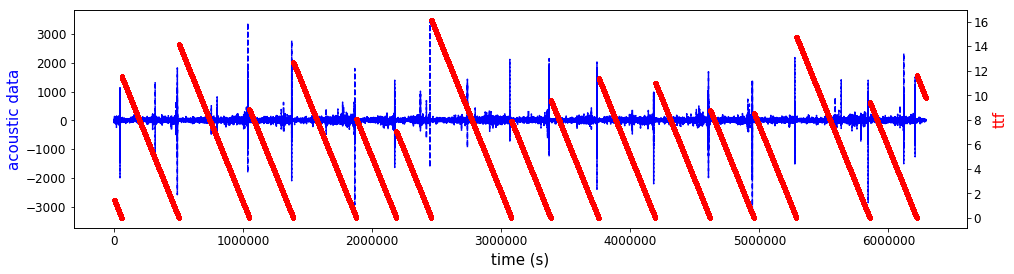

In [230]:
train_ad_sample = train_ad[::100]
train_ttf_sample = train_ttf[::100]

plot_activity(0,int(len(train_ad)/100), x_scale=2, ad_data = train_ad_sample, ttf_data = train_ttf_sample)

Let's look closer at the ttf jumps.

In [114]:
m = len(train)

In [195]:
train0 = train_ttf[:(m-1)]
train1 = train_ttf[1:]

In [196]:
jumps0 = (train0 < train1)

In [197]:
jumps = np.where(jumps0 == 1)[0]

In [198]:
jumps

array([  5656573,  50085877, 104677355, 138772452, 187641819, 218652629,
       245829584, 307838916, 338276286, 375377847, 419368879, 461811622,
       495800224, 528777114, 585568143, 621985672])

In [199]:
n_jumps = len(jumps)
n_jumps

16

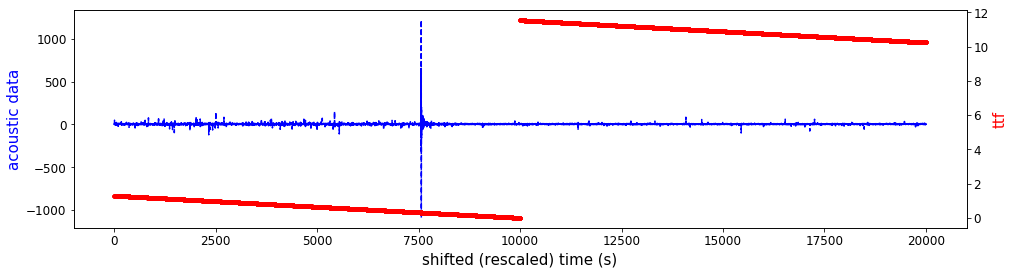

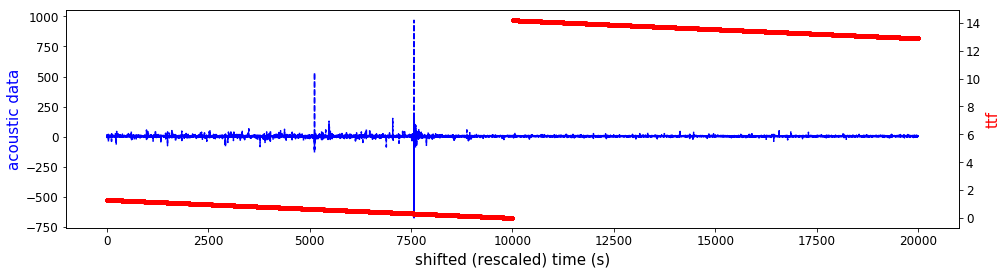

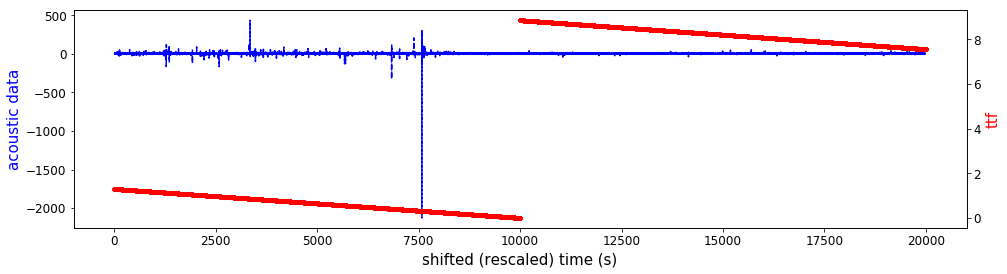

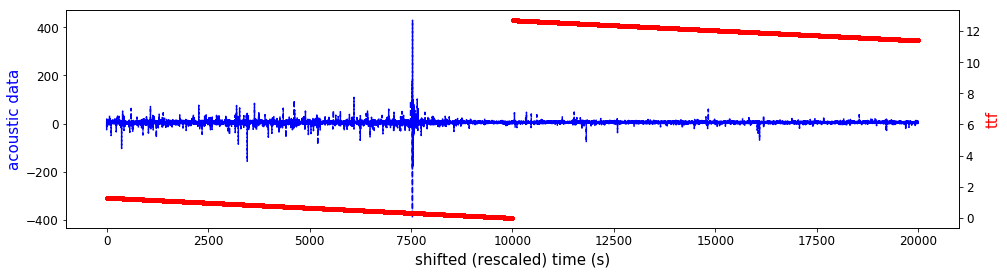

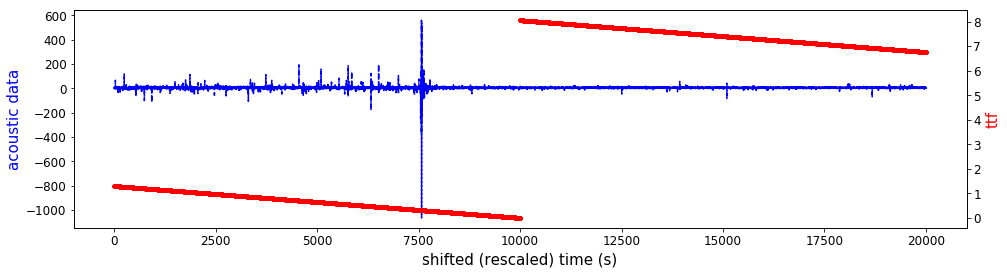

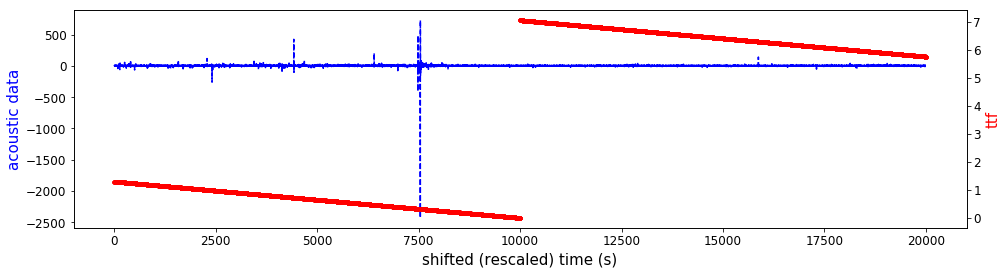

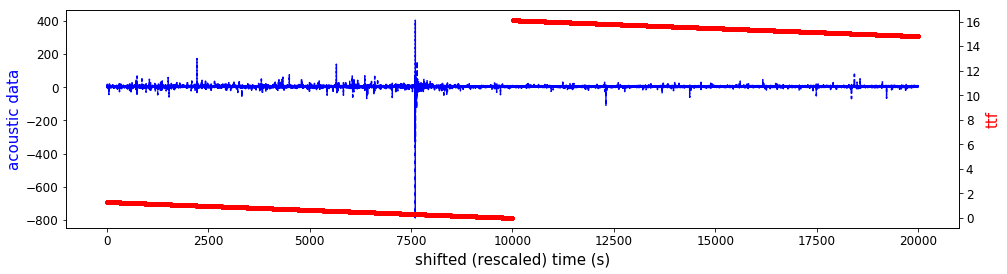

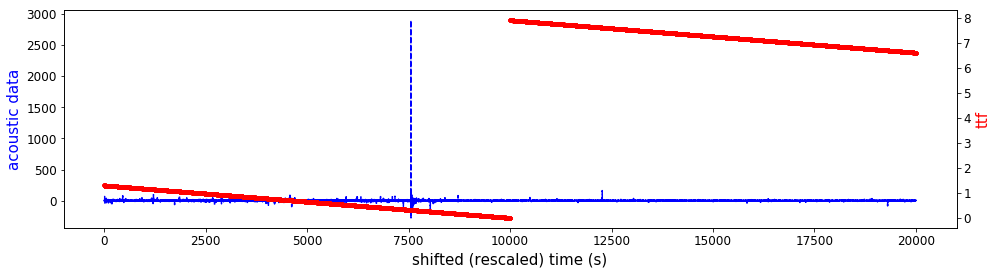

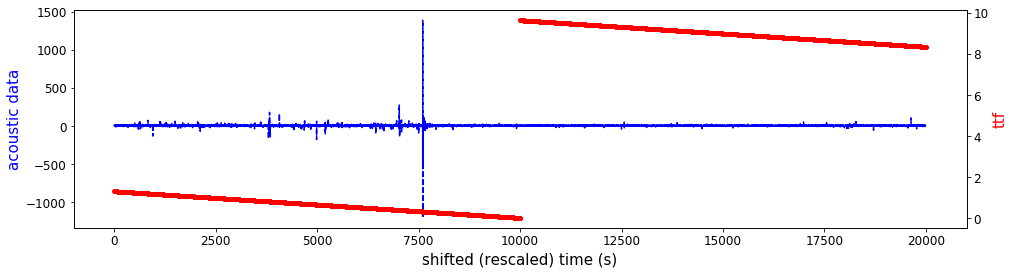

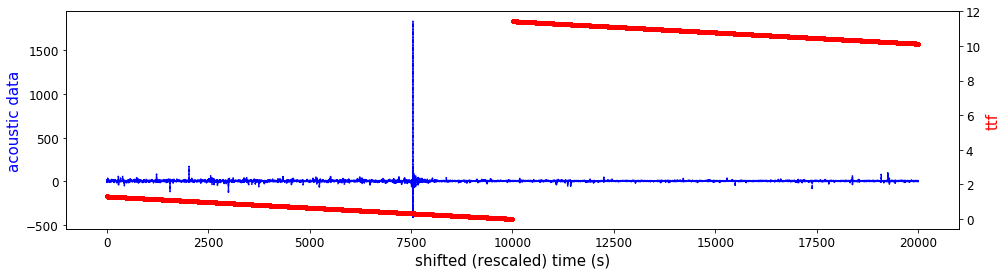

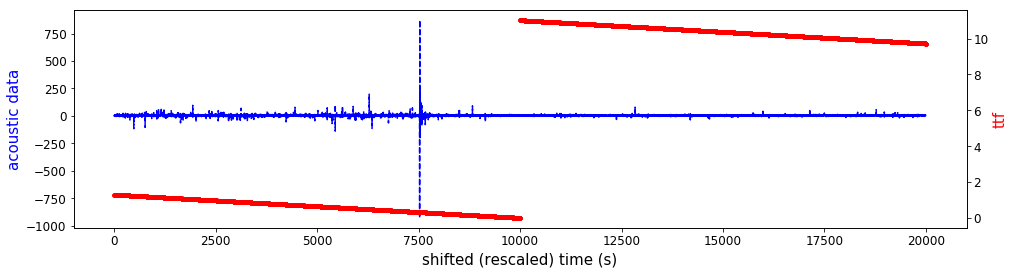

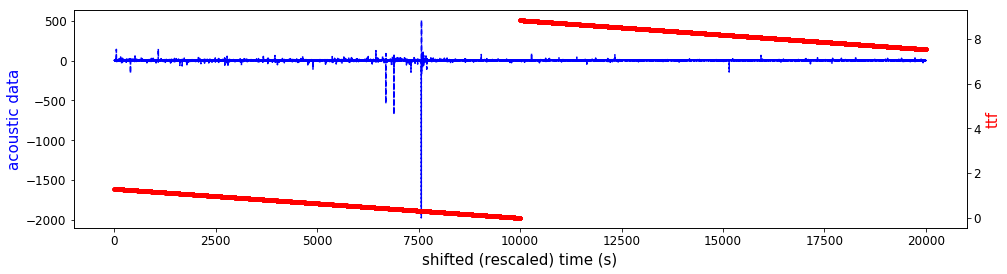

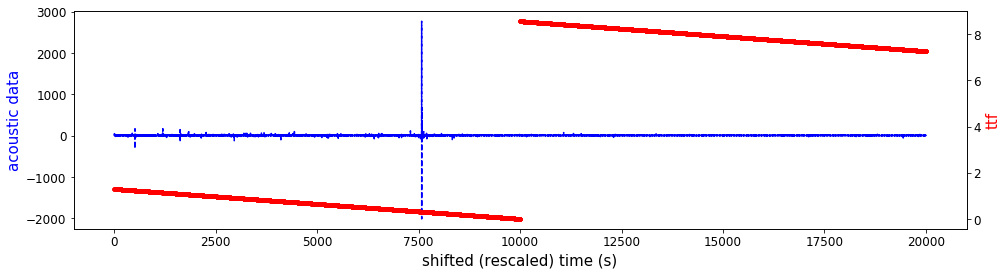

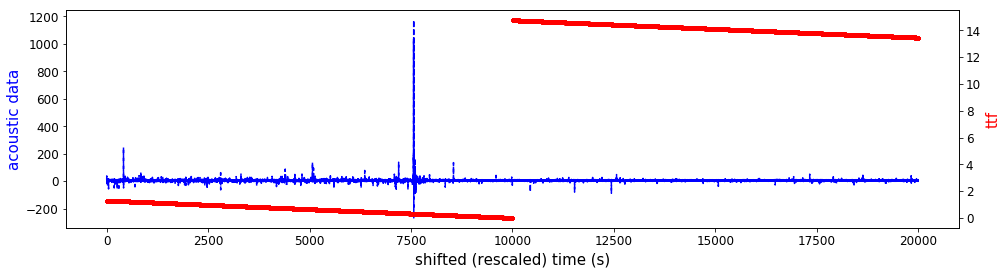

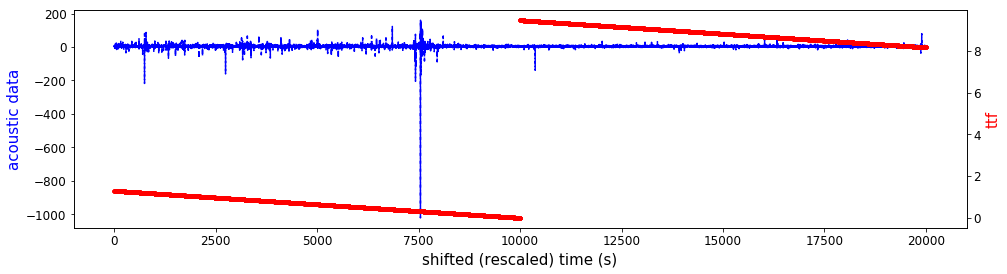

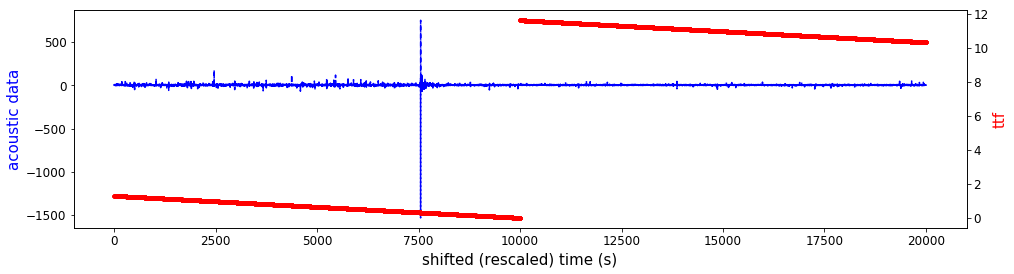

In [256]:
span = int(5*1e6)
step = int(span/10000)
m= len(train_ad)

for i in range(n_jumps):
    t0 = jumps[i]-span
    t1 = jumps[i]+span
    if t0 < 0:
        t0=0
    if t1 > m:
        t1 = m
    ad_jump = train_ad[t0:t1:step] 
    ttf_jump = train_ttf[t0:t1:step] 
    plot_activity(0, 2*int(span/200), x_scale = 2, ad_data = ad_jump, ttf_data = ttf_jump)

Some more inspection of the data

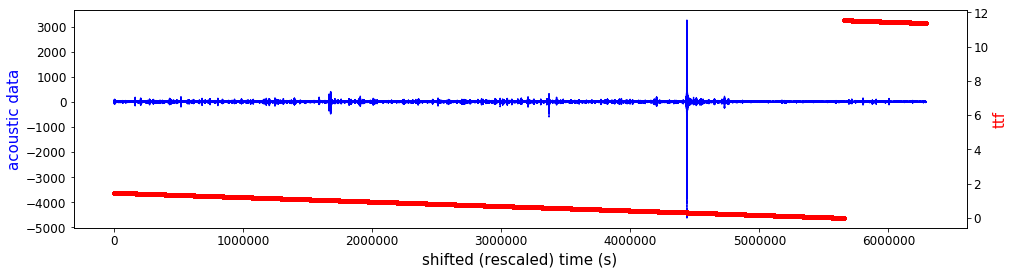

In [250]:
plot_activity(0,int(m/100), x_scale=2)

There is a time lapse of about 500x2500s (=1.25e6 s) between the ad peak and the ttf jump.

Look at the data away from the peaks

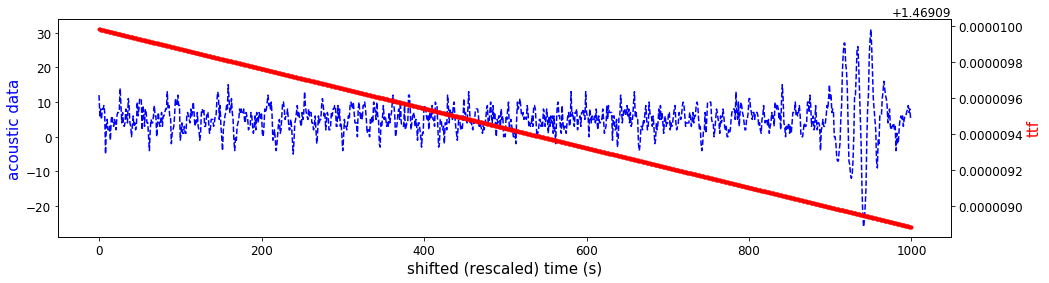

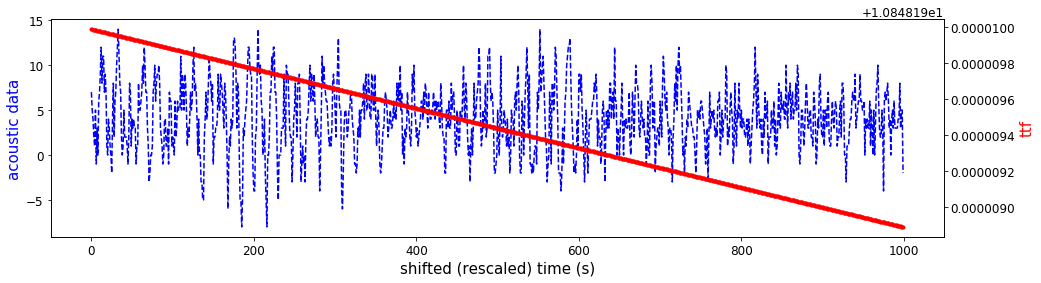

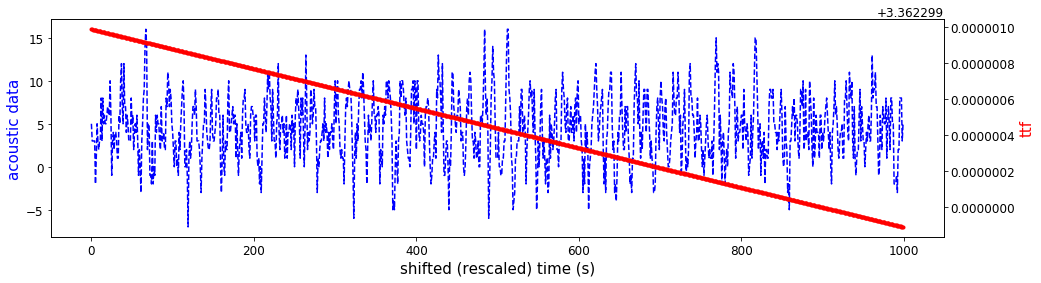

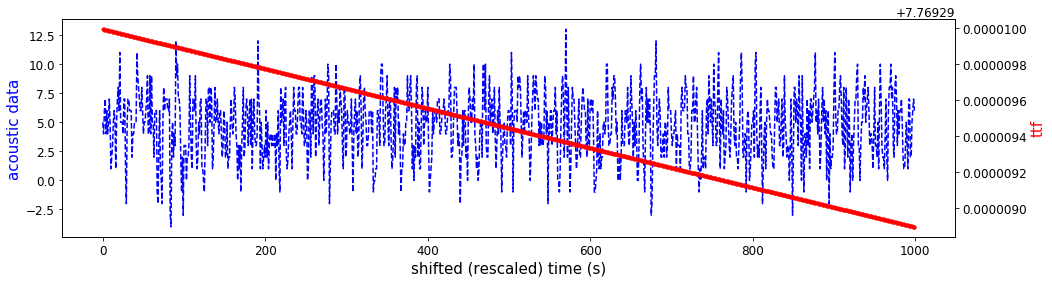

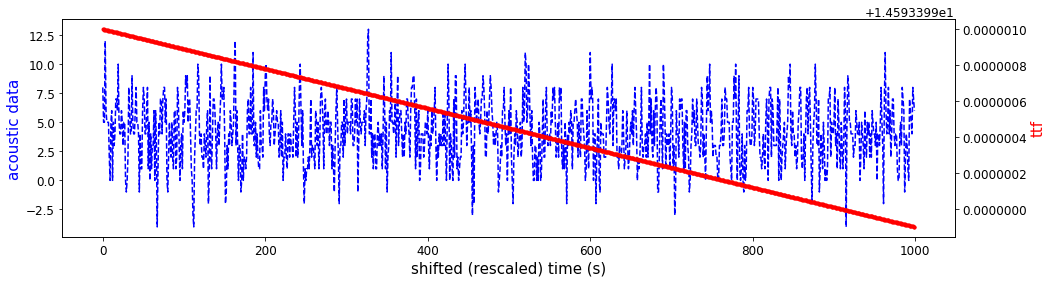

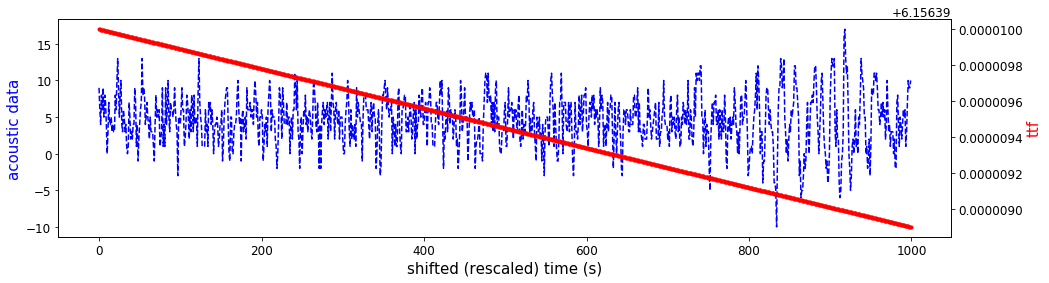

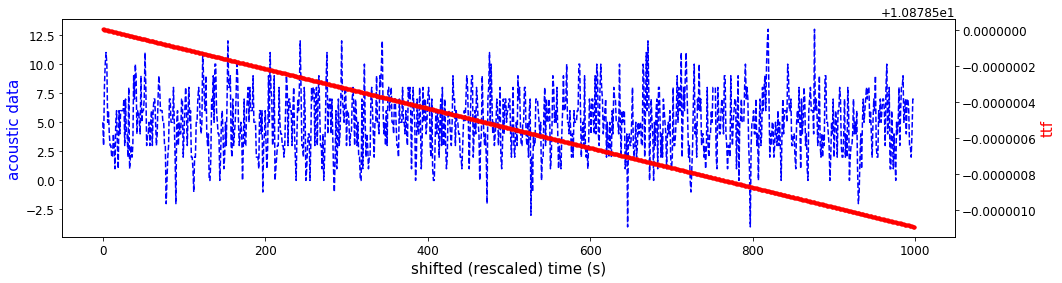

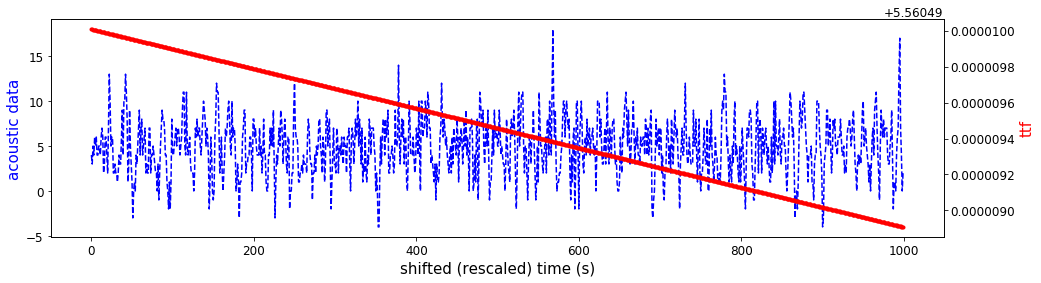

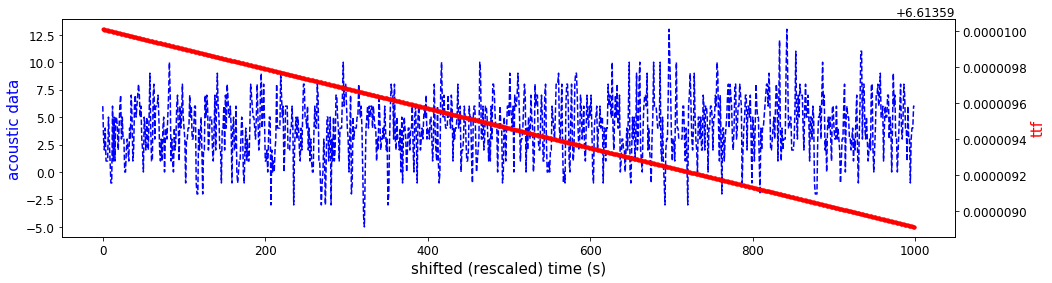

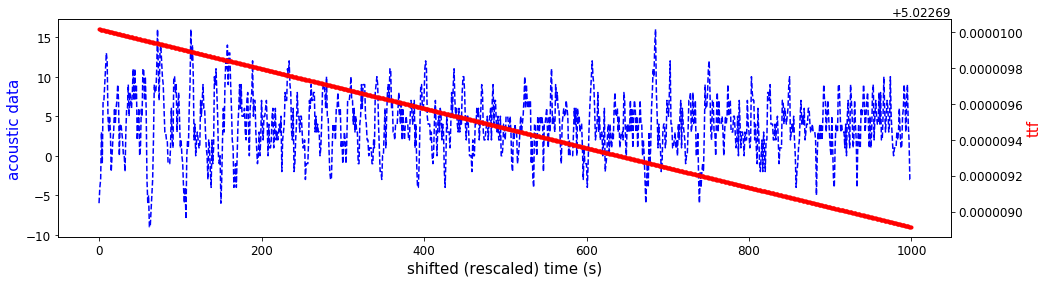

In [308]:
for i in range(10):
    plot_activity(int(i*(m/10)), 1000, x_scale=2)

In [18]:
# Auxiliary functions: 

#moving average
def moving_average(a, n) :  # a: 1d array; n: window_size.
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# rolling windows
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#sta/lta ratio

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

## Kernel Gab

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold

/Users/Benjamin/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [42]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [43]:
def create_features_gab(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [72]:
def create_features_03(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.divide(np.diff(xc), xc[:-1], out=np.zeros(150000-1), where= xc[:-1] != 0))
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    #X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    xc_max = xc.max()
    xc_min = xc.min()
    X.loc[seg_id, 'max_to_min'] = np.divide(xc_max, np.abs(xc_min), out = np.zeros(1), where = xc_min != 0) 
    X.loc[seg_id, 'max_to_min_diff'] = xc_max - np.abs(xc_min)
    #X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    #X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.divide(np.diff(xc[:50000]), xc[:50000][:-1], out=np.zeros(50000-1), where= xc[:50000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.divide(np.diff(xc[-50000:]), xc[-50000:][:-1], out=np.zeros(50000-1), where= xc[-50000:][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.divide(np.diff(xc[:10000]), xc[:10000][:-1], out=np.zeros(10000-1), where= xc[:10000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.divide(np.diff(xc[-10000:]), xc[-10000:][:-1], out=np.zeros(10000-1), where= xc[-10000:][:-1] != 0))
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    #X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    #X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    #X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    #X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.divide(np.diff(x_roll_std), x_roll_std[:-1], out= np.zeros(len(x_roll_std)-1), where= x_roll_std[:-1] !=0))
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        #X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.divide(np.diff(x_roll_mean), x_roll_mean[:-1], out=np.zeros(len(x_roll_mean)-1), where= x_roll_mean[:-1]!=0))
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [203]:
def create_features_04(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_100'] = realFFT[-100:].mean()
    X.loc[seg_id, 'Rstd__last_100'] = realFFT[-100:].std()
    X.loc[seg_id, 'Rmean_last_1000'] = realFFT[-1000:].mean()
    X.loc[seg_id, 'Rstd__last_1000'] = realFFT[-1000:].std()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.divide(np.diff(xc), xc[:-1], out=np.zeros(150000-1), where= xc[:-1] != 0))
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    #X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    xc_max = xc.max()
    xc_min = xc.min()
    X.loc[seg_id, 'max_to_min'] = np.divide(xc_max, np.abs(xc_min), out = np.zeros(1), where = xc_min != 0) 
    X.loc[seg_id, 'max_to_min_diff'] = xc_max - np.abs(xc_min)
    #X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    #X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.divide(np.diff(xc[:50000]), xc[:50000][:-1], out=np.zeros(50000-1), where= xc[:50000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.divide(np.diff(xc[-50000:]), xc[-50000:][:-1], out=np.zeros(50000-1), where= xc[-50000:][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.divide(np.diff(xc[:10000]), xc[:10000][:-1], out=np.zeros(10000-1), where= xc[:10000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.divide(np.diff(xc[-10000:]), xc[-10000:][:-1], out=np.zeros(10000-1), where= xc[-10000:][:-1] != 0))
    
    #X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    #X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    #X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    #X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    #X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    #X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    #X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    #X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    #X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    #X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    #X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    #ewma = pd.Series.ewm
    #X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    #X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    #X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    #no_of_std = 2
    #X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    #X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    #X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    #X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    #X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    #X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    #X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    #X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.divide(np.diff(x_roll_std), x_roll_std[:-1], out= np.zeros(len(x_roll_std)-1), where= x_roll_std[:-1] !=0))
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        #X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.divide(np.diff(x_roll_mean), x_roll_mean[:-1], out=np.zeros(len(x_roll_mean)-1), where= x_roll_mean[:-1]!=0))
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [204]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [205]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float32)
train_y = pd.DataFrame(index=range(segments), dtype=np.float32, columns=['time_to_failure'])

In [206]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [207]:
train_y.size

4194

In [208]:
train_y.to_csv('train_test/train_y.csv',index=False)

In [215]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features_04(seg_id, seg, train_X)

In [216]:
train_X.shape

(4194, 130)

In [217]:
train_X.to_csv('train_test/train_X_04_moreR.csv',index=False)

### Creating more segments

In [92]:
segments

4194

In [93]:
train_X_bis = pd.DataFrame(index=range(segments-1), dtype=np.float32)

In [94]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.5)*rows):int((seg_id + 1.5)*rows)]
    create_features_03(seg_id, seg, train_X_bis)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [129]:
train_X_1q = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_3q = pd.DataFrame(index=range(segments-1), dtype=np.float32)

In [130]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.25)*rows):int((seg_id + 1.25)*rows)]
    create_features_03(seg_id, seg, train_X_1q)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [131]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.75)*rows):int((seg_id + 1.75)*rows)]
    create_features_03(seg_id, seg, train_X_3q)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [106]:
train_y_bis = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])

In [107]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.5)*rows):int((seg_id + 1.5)*rows)]
    train_y_bis.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [99]:
train_X = pd.concat([train_X, train_X_bis], ignore_index=True)

In [114]:
train_y = pd.concat([train_y, train_y_bis], ignore_index=True)

In [132]:
train_y_1q = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_3q = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])

In [133]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.25)*rows):int((seg_id + 1.25)*rows)]
    train_y_1q.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.75)*rows):int((seg_id + 1.75)*rows)]
    train_y_3q.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [134]:
train_X = pd.concat([train_X, train_X_1q, train_X_3q], ignore_index=True)
train_y = pd.concat([train_y, train_y_1q, train_y_3q], ignore_index=True)

Even more training data

In [146]:
train_X_18th = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_38th = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_58th = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_78th = pd.DataFrame(index=range(segments-1), dtype=np.float32)

In [147]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 1/8)*rows):int((seg_id + 1/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_18th)
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 3/8)*rows):int((seg_id + 3/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_38th)
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 5/8)*rows):int((seg_id + 5/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_58th)
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 7/8)*rows):int((seg_id + 7/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_78th)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [144]:
train_y_18th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_38th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_58th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_78th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])

In [145]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 1/8)*rows):int((seg_id + 1/8 + 1)*rows)]
    train_y_18th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 3/8)*rows):int((seg_id + 3/8 +1)*rows)]
    train_y_38th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 5/8)*rows):int((seg_id + 5/8 + 1)*rows)]
    train_y_58th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 7/8)*rows):int((seg_id + 7/8 +1)*rows)]
    train_y_78th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [148]:
train_X = pd.concat([train_X, train_X_18th, train_X_38th, train_X_58th, train_X_78th], ignore_index=True)
train_y = pd.concat([train_y, train_y_18th, train_y_38th, train_y_58th, train_y_78th], ignore_index=True)

In [149]:
print(train_X.shape, train_y.shape)

(33545, 144) (33545, 1)


In [150]:
train_X.to_csv('train_X_03_x8.csv',index=False)

In [151]:
train_y.to_csv('train_y_x8.csv',index=False)

### Getting back train_X and train_y (if program crashed)

In [178]:
train_X = pd.read_csv("train_X_03.csv")
train_y = pd.read_csv("train_y.csv")

In [179]:
train_X.shape

(4194, 144)

In [168]:
train_y.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274399


### Scaling

In [218]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [181]:
scaled_train_X.head(3)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.218194,0.193218,1.199316,-0.105007,1.424140,0.156736,-0.304021,-0.169052,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-0.003189,-0.004742
1,0.805716,0.004734,0.063936,-0.018037,0.078886,-0.008599,0.805716,-0.222118,-0.584087,0.007212,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.001041,0.007341
2,1.511155,0.049252,-0.086289,0.163039,0.078886,0.043800,1.511155,-0.104254,1.012290,0.054839,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.001473,0.099556


### Preparing Test set

In [219]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float32, index=submission.index)

In [220]:
submission.shape, test_X.shape

((2624, 1), (2624, 130))

In [221]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('datasets/test/' + seg_id + '.csv')
    create_features_04(seg_id, seg, test_X)

In [222]:
test_X.to_csv('train_test/test_X_04_moreR.csv',index=False)

Getting back test_X if program crashed

In [20]:
test_X = pd.read_csv("test_X_03.csv")

In [223]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [172]:
scaled_test_X.tail(3)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2621,-3.009655,0.343517,0.537541,-0.581106,-0.228513,0.174496,-3.009655,-0.487273,-0.081350,0.341256,...,-0.165019,-0.130403,-0.336428,-1.574749,-2.621306,-2.946719,-1.940798,1.600577,0.016816,-0.130403
2622,-0.694013,0.782194,0.728146,-0.641513,-0.228513,0.628416,-0.694013,-1.110252,-1.783425,0.778474,...,-0.043986,0.055327,-0.179459,-0.307526,-0.679682,-0.758504,0.008242,0.911976,0.025259,0.055327
2623,-1.248295,-0.349365,-0.331178,0.347644,0.221203,-0.305685,-1.248294,0.384201,-0.790548,-0.349867,...,-0.254687,-0.248075,0.047367,-0.502001,-0.971466,-1.268484,-0.816353,-0.563958,-0.004362,-0.248075


### Training

In [224]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

params = {'num_leaves': 24, #50,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.8, #0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8, #0.9,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [225]:
from lightgbm import LGBMRegressor

In [226]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = LGBMRegressor(**params, n_estimators = 40000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.10115	valid_1's l1: 2.26432
[2000]	training's l1: 1.82318	valid_1's l1: 2.13058
[3000]	training's l1: 1.67419	valid_1's l1: 2.10065
[4000]	training's l1: 1.55971	valid_1's l1: 2.09597
Early stopping, best iteration is:
[4423]	training's l1: 1.51692	valid_1's l1: 2.09553
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.09151	valid_1's l1: 2.26594
[2000]	training's l1: 1.814	valid_1's l1: 2.13215
[3000]	training's l1: 1.66871	valid_1's l1: 2.10121
[4000]	training's l1: 1.55587	valid_1's l1: 2.0941
[5000]	training's l1: 1.45957	valid_1's l1: 2.09236
Early stopping, best iteration is:
[4998]	training's l1: 1.45973	valid_1's l1: 2.09231
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.10297	valid_1's l1: 2.27648
[2000]	training's l1: 1.83134	valid_1's l1: 2.10922
[3000]	training's l1: 1.6827	valid_1's l1: 2.07

### Feature importances

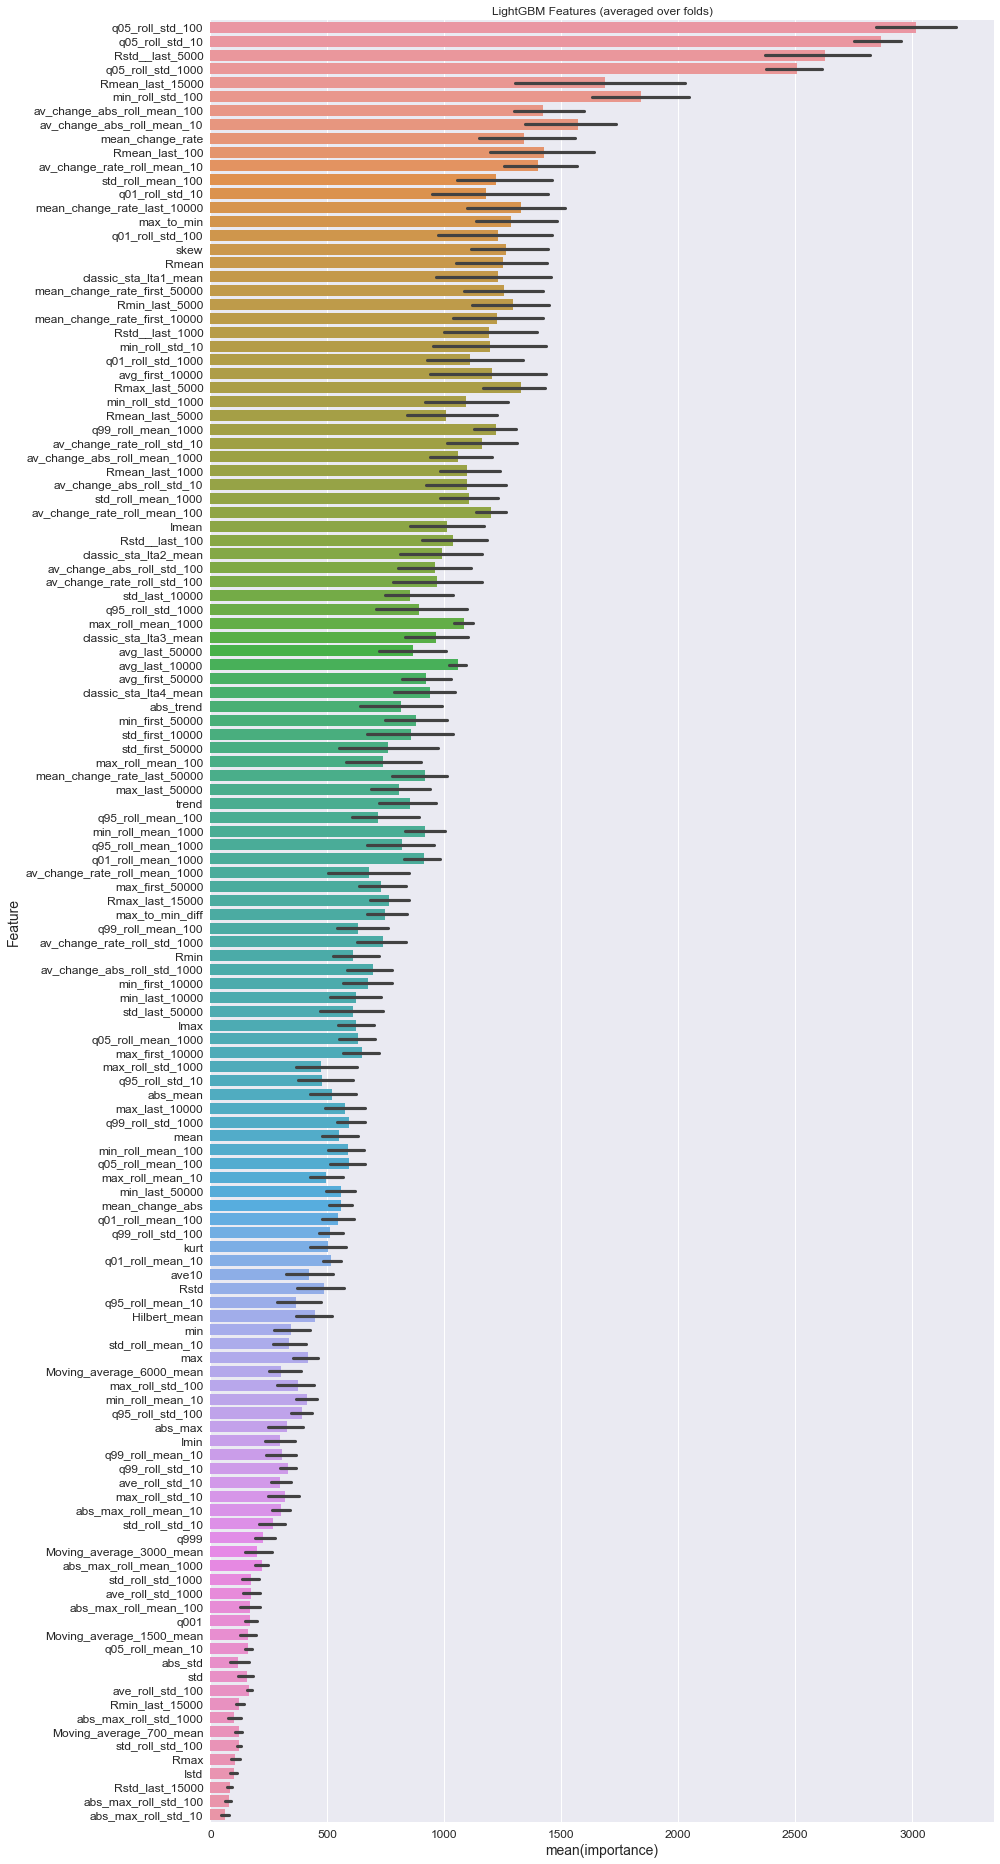

In [227]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
#plt.savefig('feature importances/lgbm_importances_04_v2.png')

### Submission

In [228]:
submission.time_to_failure = predictions
submission.to_csv('predictions/submission_04_moreR.csv',index=True)

## Other models (with features 04): Gradient boosting and blending

In [253]:
from tqdm import tqdm_notebook
from sklearn.svm import NuSVR, SVR
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge

In [231]:
train_X = pd.read_csv("train_test/train_X_04.csv")
train_y = pd.read_csv("train_test/train_y.csv")
test_X = pd.read_csv("train_test/test_X_04.csv")

In [234]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

X_train_scaled = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)
y_tr = train_y

In [235]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [249]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Sat Jun  1 15:26:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1205]	training's l1: 1.58717	valid_1's l1: 2.06463
Fold 1 started at Sat Jun  1 15:26:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1295]	training's l1: 1.57343	valid_1's l1: 2.02096
Fold 2 started at Sat Jun  1 15:26:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1520]	training's l1: 1.47162	valid_1's l1: 2.11194
Fold 3 started at Sat Jun  1 15:27:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1129]	training's l1: 1.65106	valid_1's l1: 1.9058
Fold 4 started at Sat Jun  1 15:27:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1174]	training's l1: 1.60043	valid_1's l1: 2.07276
CV mean score: 2.0352, std: 0.0709.


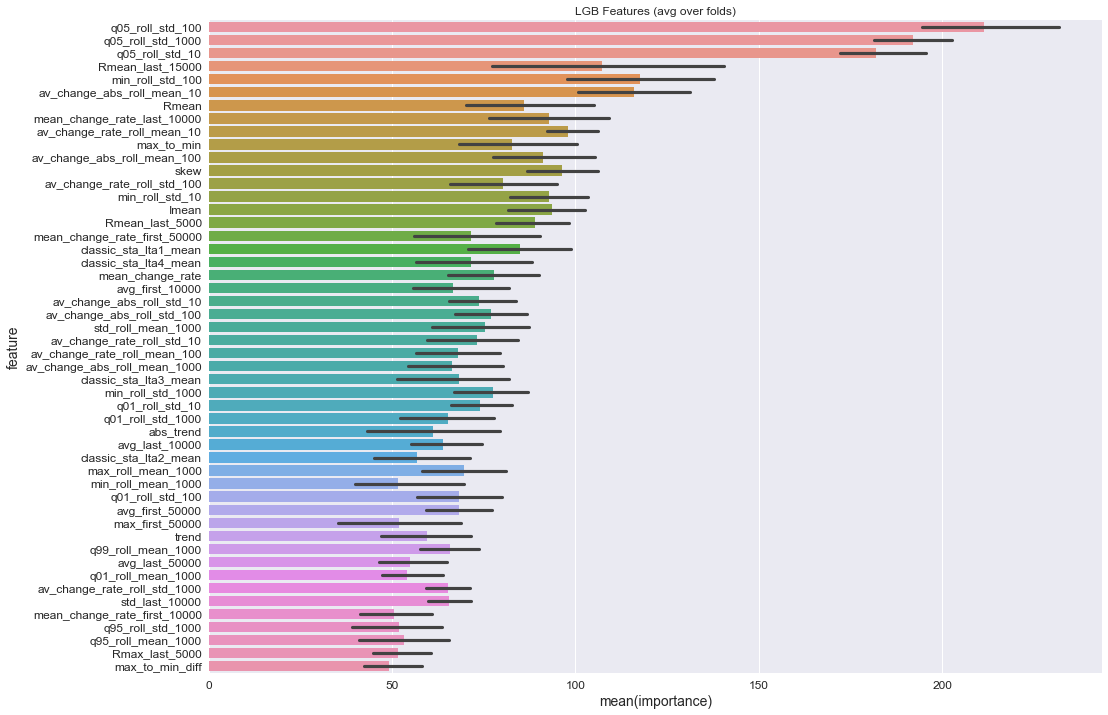

In [247]:
params = {'num_leaves': 24, #128,
          'min_data_in_leaf': 80, #79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.81,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.13,
          'reg_lambda': 0.36
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', 
                                                          plot_feature_importance=True)

In [254]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb')

Fold 0 started at Sat Jun  1 15:46:29 2019
[0]	train-mae:5.03515	valid_data-mae:5.18035
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[95]	train-mae:0.836992	valid_data-mae:2.1488

Fold 1 started at Sat Jun  1 15:46:53 2019
[0]	train-mae:5.06032	valid_data-mae:5.07195
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[103]	train-mae:0.80931	valid_data-mae:2.04534

Fold 2 started at Sat Jun  1 15:47:18 2019
[0]	train-mae:5.05387	valid_data-mae:5.09732
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[110]	train-mae:0.755754	valid_data-mae:2.13303

Fold 3 started at Sat Jun  1 15:47:43 2019
[0]	train

In [255]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, 
                                      model_type='sklearn', model=model)

Fold 0 started at Sat Jun  1 15:50:01 2019
Fold 0. MAE: 2.0945.

Fold 1 started at Sat Jun  1 15:50:05 2019
Fold 1. MAE: 2.0997.

Fold 2 started at Sat Jun  1 15:50:09 2019
Fold 2. MAE: 2.1399.

Fold 3 started at Sat Jun  1 15:50:13 2019
Fold 3. MAE: 1.9669.

Fold 4 started at Sat Jun  1 15:50:17 2019
Fold 4. MAE: 2.1008.

CV mean score: 2.0803, std: 0.0590.


In [256]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, 
                                        model_type='sklearn', model=model)

Fold 0 started at Sat Jun  1 15:51:41 2019
Fold 0. MAE: 2.0853.

Fold 1 started at Sat Jun  1 15:51:44 2019
Fold 1. MAE: 2.0676.

Fold 2 started at Sat Jun  1 15:51:47 2019
Fold 2. MAE: 2.1316.

Fold 3 started at Sat Jun  1 15:51:49 2019
Fold 3. MAE: 1.9182.

Fold 4 started at Sat Jun  1 15:51:52 2019
Fold 4. MAE: 2.0804.

CV mean score: 2.0566, std: 0.0725.


In [257]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='cat')


Fold 0 started at Sat Jun  1 15:53:15 2019
Fold 1 started at Sat Jun  1 16:21:56 2019
Fold 2 started at Sat Jun  1 16:51:43 2019
Fold 3 started at Sat Jun  1 17:21:07 2019
Fold 4 started at Sat Jun  1 17:47:59 2019
CV mean score: 2.0259, std: 0.0690.


In [258]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, 
                                  model_type='sklearn', model=model)

Fold 0 started at Sat Jun  1 18:19:28 2019
Fold 0. MAE: 2.1820.

Fold 1 started at Sat Jun  1 18:19:30 2019
Fold 1. MAE: 2.1637.

Fold 2 started at Sat Jun  1 18:19:31 2019
Fold 2. MAE: 2.1928.

Fold 3 started at Sat Jun  1 18:19:32 2019
Fold 3. MAE: 1.9866.

Fold 4 started at Sat Jun  1 18:19:33 2019
Fold 4. MAE: 2.2038.

CV mean score: 2.1458, std: 0.0807.


In [260]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr + prediction_svr1 
                                 + prediction_cat) / 5
print(submission.head())
submission.to_csv('predictions/submission_blending.csv')

              time_to_failure
seg_id                       
seg_00030f  2.755833025437171
seg_0012b5  5.661783470714634
seg_00184e  5.303778652584595
seg_003339  8.225861378109185
seg_0042cc  6.339169543719257


# 1d CNN

In [6]:
# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


tf.set_random_seed(42)
np.random.seed(42)

In [7]:
import tensorflow.contrib.slim as slim
#from tensorflow.python.layers import base

def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

In [8]:
# Not using keras

he_init = tf.variance_scaling_initializer()

def fc_layer(inputs, n_neurons, training, activation = tf.nn.elu,
             initializer= he_init, dropout_rate= 0, name=None):
    with tf.variable_scope(name,'fc'):
        outputs = tf.layers.dense(inputs, n_neurons, activation=activation, kernel_initializer = initializer)
        dropout = tf.layers.dropout(outputs, dropout_rate, training=training)
        return dropout
    
def cnn_1d_layer(inputs, n_fmaps, conv_ksize, training, conv_strides=1, conv_pad = "SAME", name=None, 
                 activation = tf.nn.elu, initializer= he_init,
                 pool_size=2, pool_strides=2, pool_pad="VALID", dropout_rate=0):
    with tf.variable_scope(name,'cnn'):
        conv = tf.layers.conv1d(inputs, filters=n_fmaps, kernel_size = conv_ksize, 
                                       strides = conv_strides, padding=conv_pad,
                                      activation=activation, kernel_initializer=initializer)
        pool = tf.layers.max_pooling1d(conv, pool_size= pool_size, strides=pool_strides,
                                        padding = pool_pad)
        dropout = tf.layers.dropout(pool, rate=dropout_rate, training=training)
        return dropout

In [16]:
# Using keras
he_init = tf.variance_scaling_initializer()

def fc_layer(inputs, n_neurons, activation = tf.nn.elu,
             initializer= he_init, use_bias=False, dropout_rate= 0, name=None):
    with tf.variable_scope(name,'fc'):
        outputs = tf.keras.layers.Dense(n_neurons, activation=activation, 
                                     kernel_initializer = initializer, use_bias=use_bias)(inputs)
        dropout = tf.keras.layers.Dropout(rate=dropout_rate)(outputs)
        return dropout
    
def cnn_1d_layer(inputs, n_fmaps, conv_ksize, conv_strides=1, conv_pad = "SAME", name=None, 
                 activation = tf.nn.elu, initializer= he_init, use_bias=False,
                 pool_size=2, pool_strides=2, pool_pad="VALID", dropout_rate=0):
    with tf.variable_scope(name,'cnn'):
        conv = tf.keras.layers.Conv1D(filters=n_fmaps, kernel_size = conv_ksize, 
                                       strides = conv_strides, padding=conv_pad,
                                      activation=activation, kernel_initializer=initializer,
                                      use_bias=use_bias)(inputs)
        pool = tf.keras.layers.MaxPool1D(pool_size= pool_size, strides=pool_strides,
                                        padding = pool_pad)(conv)
        dropout = tf.keras.layers.Dropout(rate=dropout_rate)(pool)
        return dropout

In [49]:
# Parameters of CNN

n_inputs = 150000

cnn_params = [(64,256,64,4,4,0.1),   #(n_fmaps, conv_ksize, conv_strides, pool_size, pool_strides, dropout_rate)
              (8,16,4,2,2,0.1),
             ]


n_fc1 = 24     # number of neurons of the fully connected layer
fc1_dropout_rate = 0.1
n_fc2 = 16    
fc2_dropout_rate = 0



# Defining the graph
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    y = tf.placeholder(tf.float32, shape=[None,1], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')


X0 = tf.reshape(X,[-1,150000,1])
cnn = tf.layers.average_pooling1d(X0, pool_size= 2, strides=2, padding = "SAME")
print(cnn.shape)
for n_fmaps, conv_ksize, conv_strides, pool_size, pool_strides, dropout_rate in cnn_params:
    cnn = cnn_1d_layer(cnn, n_fmaps, conv_ksize, training, conv_strides=conv_strides,
                       pool_size=pool_size, pool_strides=pool_strides, 
                       dropout_rate=dropout_rate)
    print(cnn.shape)


#cnn_t = tf.transpose(cnn,[0,2,1])
cnn_flat = tf.layers.Flatten()(cnn)
print(cnn_flat.shape)
cnn_reshaped = tf.reshape(cnn_flat,[-1,cnn_flat.shape[1],1])
pool1 = tf.layers.max_pooling1d(cnn_reshaped, pool_size= 2, strides=2, padding = "same")
print(pool1.shape)
pool1_reshaped = tf.layers.Flatten()(pool1)
fc1 = fc_layer(pool1_reshaped, n_fc1, training, dropout_rate = fc1_dropout_rate, activation = "softmax")
print(fc1.shape)
outputs = fc_layer(fc1, 1, training, activation = None)
print(outputs.shape)

with tf.name_scope("train"):
    loss = tf.reduce_mean(tf.abs(tf.subtract(y, outputs)))
    #loss = tf.losses.mean_squared_error(y, outputs)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
#with tf.name_scope("eval"):
#    accuracy = tf.metrics.mean_absolute_error(y, outputs)[0]

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

(?, 75000, 1)
(?, 293, 64)
(?, 37, 8)
(?, 296)
(?, 148, 1)
(?, 24)
(?, 1)


In [50]:
model_summary()

---------
Variables: name (type shape) [size]
---------
cnn/conv1d/kernel:0 (float32_ref 256x1x64) [16384, bytes: 65536]
cnn/conv1d/bias:0 (float32_ref 64) [64, bytes: 256]
cnn_1/conv1d/kernel:0 (float32_ref 16x64x8) [8192, bytes: 32768]
cnn_1/conv1d/bias:0 (float32_ref 8) [8, bytes: 32]
fc/dense/kernel:0 (float32_ref 148x24) [3552, bytes: 14208]
fc/dense/bias:0 (float32_ref 24) [24, bytes: 96]
fc_1/dense/kernel:0 (float32_ref 24x1) [24, bytes: 96]
fc_1/dense/bias:0 (float32_ref 1) [1, bytes: 4]
Total size of variables: 28249
Total bytes of variables: 112996


### Train/Valid/Test data

In [12]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [13]:
X_train_cnn = np.zeros([segments, rows], dtype=np.float32)
y_train_cnn = np.zeros(segments, dtype=np.float32)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for seg_id in range(segments):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    X_train_cnn[seg_id] = seg["acoustic_data"].values
    y_train_cnn[seg_id] = seg["time_to_failure"].values[-1]

X_train_cnn = scaler.fit_transform(X_train_cnn)

In [14]:
X_valid_cnn, X_train_cnn = X_train_cnn[:1000], X_train_cnn[1000:]
y_valid_cnn, y_train_cnn = y_train_cnn[:1000], y_train_cnn[1000:]

In [15]:
n_seg_test = len(test)
print("Number of test segments: ", n_seg_test)

Number of test segments:  2624


In [16]:
X_test_cnn = np.zeros([n_seg_test, rows], dtype=np.float32)

for seg_id in range(n_seg_test):
    X_test_cnn[seg_id] = test[seg_id]["acoustic_data"].values
    
X_test_cnn = scaler.fit_transform(X_test_cnn)

### Running the graph

In [17]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

Functions to speed up early stopping operations

In [18]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [51]:
n_epochs = 10
batch_size = 20
iteration = 0

best_loss_val = np.infty
check_interval = 10
checks_since_last_progress = 0
max_checks_without_progress = 10
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_cnn, y_train_cnn.reshape(-1,1), batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_valid_cnn, y: y_valid_cnn.reshape(-1,1)})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        #acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_batch = loss.eval(feed_dict={X: X_batch, y: y_batch})
        #acc_val = accuracy.eval(feed_dict={X: X_valid_cnn, y: y_valid_cnn.reshape(-1,1)})
        acc_val = loss.eval(feed_dict={X: X_valid_cnn, y: y_valid_cnn.reshape(-1,1)})
        print("Epoch {}, last batch accuracy: {:.4f}, valid. accuracy: {:.4f}, valid. best loss: {:.6f}".format(
                  epoch, acc_batch, acc_val, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
        save_path = saver.save(sess, "./my_cnn_model_01")

Epoch 0, last batch accuracy: 5.6870, valid. accuracy: 5.6155, valid. best loss: 5.630755
Epoch 1, last batch accuracy: 3.9344, valid. accuracy: 5.3584, valid. best loss: 5.371272
Epoch 2, last batch accuracy: 4.6980, valid. accuracy: 5.1281, valid. best loss: 5.137587
Epoch 3, last batch accuracy: 4.6823, valid. accuracy: 4.9258, valid. best loss: 4.933223
Epoch 4, last batch accuracy: 1.8662, valid. accuracy: 4.7383, valid. best loss: 4.744006
Epoch 5, last batch accuracy: 2.7630, valid. accuracy: 4.5751, valid. best loss: 4.579528
Epoch 6, last batch accuracy: 3.6370, valid. accuracy: 4.4245, valid. best loss: 4.427456
Epoch 7, last batch accuracy: 3.7137, valid. accuracy: 4.2889, valid. best loss: 4.290386
Epoch 8, last batch accuracy: 3.7685, valid. accuracy: 4.1710, valid. best loss: 4.171784
Epoch 9, last batch accuracy: 3.1405, valid. accuracy: 4.0655, valid. best loss: 4.065467


### Submission

In [ ]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id')

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,"./my_cnn_model_01.ckpt")
    predictions = outputs.eval(feed_dict={X:X_test_cnn})
    submission.time_to_failure = predictions

submission.to_csv('predictions/submission_cnn_01.csv',index=True)

## Keras Kernel

In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.set_random_seed(42)
np.random.seed(42)

In [53]:
df = pd.read_csv('datasets/train.csv',
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [54]:
class DataTrainTestSplit(object):
    """ Warning: The validation set should be statistically significant.
    
    There are 16 failures in the dataset.
    """
    def __init__(self, n_blocks=16, split=0.2):
        self.n_blocks = n_blocks
        perm = np.random.permutation(n_blocks)
        test_samples = int(np.floor(n_blocks * split))
        self.train_slice = perm[:-test_samples]
        self.test_slice = perm[-test_samples:]
    def train(self):
        return self.train_slice
    def test(self):
        return self.test_slice

In [56]:
import linear_signal_py as linear_signal

class SignalFeatures(linear_signal.SignalFeatureGenerator):
    SEQUENCE_LENGHT = 150_000

    S_MEAN = 4
    S_STD = 10

    def __init__(self, normalize=True):
        self.normalize = normalize

    def shape(self):
        return (self.SEQUENCE_LENGHT, 1)

    def generate(self, df: pd.DataFrame, predict=False):
        """ The performance of this function when vectorized is 10x of
        an iterative loop.
        """
        X = df['acoustic_data'].values[:, np.newaxis]
        if self.normalize:
            X = (X - self.S_MEAN) / self.S_STD
        if predict:
            return X
        y = df['time_to_failure'].iloc[df.shape[0] - 1]
        return X, np.array([y])

In [57]:
kFolds = [ DataTrainTestSplit(n_blocks=256, split=0.20) for _ in range(5) ]

In [58]:
SEGMENT_SIZE = 150_000
STRIDES = 15_000

def get_generators(spliter):
    ds_train = linear_signal.LinearDatasetAccessor(df, spliter.n_blocks, spliter.train())
    ds_eval = linear_signal.LinearDatasetAccessor(df, spliter.n_blocks, spliter.test())

    gen_train = linear_signal.LinearSignalGenerator(
        ds_train, SEGMENT_SIZE, SignalFeatures(), strides=STRIDES, batch_size=64)
    gen_eval = linear_signal.LinearSignalGenerator(
        ds_eval, SEGMENT_SIZE, SignalFeatures(), strides=25_000)

    return gen_train, gen_eval

In [59]:
from tensorflow import keras

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K

def make_layer(inp, index, filters, kernel_size, strides=1):
    c = Conv1D(filters, kernel_size, strides=strides, name='layer_{0}_conv'.format(index), activation='relu')(inp)
    p = MaxPooling1D(name='layer_{0}_pool'.format(index))(c)
    d = Dropout(0.1)(p)
    return d

class range_initializer(keras.initializers.Initializer):
    def __init__(self, vmax, vmean):
        self.vmax = vmax
        self.vmean = vmean
    def __call__(self, shape, dtype=None, partition_info=None):
        if len(shape) != 2 or shape[1] != 1:
            raise ValueError('Expected shape (N, 1), got ', shape)
        return np.arange(shape[0])[:, np.newaxis] / shape[0] * self.vmax - self.vmean

def make_model():
    inp = Input(shape=SignalFeatures().shape())
    
    params = [
        (16, 16, 4),
        (32, 16, 4),
        (48, 16, 4),
        (64, 8, 2),
        (32, 8, 2),
    ]

    layer_in = inp
    for i, param in enumerate(params):
        output = make_layer(layer_in, i, *param)
        layer_in = output

    p = Permute((2, 1))(output)
    s = Dense(8)(p)
    summary = Flatten()(s)

    last = Dense(24, activation='softmax')(summary)
    out = Dense(1, kernel_initializer=range_initializer(16.0, 5.6),
                bias_initializer=keras.initializers.Constant(5.6))(last)
    model = Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0005), loss='mae')
    return model

K.clear_session()
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150000, 1)         0         
_________________________________________________________________
layer_0_conv (Conv1D)        (None, 37497, 16)         272       
_________________________________________________________________
layer_0_pool (MaxPooling1D)  (None, 18748, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 18748, 16)         0         
_________________________________________________________________
layer_1_conv (Conv1D)        (None, 4684, 32)          8224      
_________________________________________________________________
layer_1_pool (MaxPooling1D)  (None, 2342, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2342, 32)          0         
__________

In [60]:
model.save('signal-conv.h5')

In [62]:
filepath="signal-conv.{0}.ckpt.hdf5"

cv_history = []

for i, spliter in enumerate(kFolds):
    model = make_model()
    gen_train, gen_val = get_generators(spliter)
    cb_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath.format(i), monitor='val_loss', verbose=True,
        save_best_only=True, mode='min')

    history = model.fit_generator(
        gen_train,
        validation_data=gen_val,
        callbacks=[cb_checkpoint],
        epochs=30)

    cv_history.append(history)

Epoch 1/30
518/519 [============================>.] - ETA: 2s - loss: 2.2622
Epoch 00001: val_loss improved from inf to 2.65259, saving model to signal-conv.0.ckpt.hdf5
519/519 [==============================] - 1105s 2s/step - loss: 2.2611 - val_loss: 2.6526
Epoch 2/30
518/519 [============================>.] - ETA: 1s - loss: 2.0968
Epoch 00002: val_loss improved from 2.65259 to 2.43772, saving model to signal-conv.0.ckpt.hdf5
519/519 [==============================] - 990s 2s/step - loss: 2.0970 - val_loss: 2.4377
Epoch 3/30
518/519 [============================>.] - ETA: 2s - loss: 2.0659
Epoch 00003: val_loss did not improve from 2.43772
519/519 [==============================] - 1245s 2s/step - loss: 2.0649 - val_loss: 2.6703
Epoch 4/30
518/519 [============================>.] - ETA: 2s - loss: 2.0492
Epoch 00004: val_loss did not improve from 2.43772
519/519 [==============================] - 1135s 2s/step - loss: 2.0499 - val_loss: 2.4748
Epoch 5/30
518/519 [===================

Epoch 13/30
518/519 [============================>.] - ETA: 1s - loss: 1.9394
Epoch 00013: val_loss did not improve from 2.21917
519/519 [==============================] - 993s 2s/step - loss: 1.9394 - val_loss: 2.2221
Epoch 14/30
518/519 [============================>.] - ETA: 1s - loss: 1.9272
Epoch 00014: val_loss did not improve from 2.21917
519/519 [==============================] - 1005s 2s/step - loss: 1.9276 - val_loss: 2.3203
Epoch 15/30
518/519 [============================>.] - ETA: 2s - loss: 1.9162
Epoch 00015: val_loss did not improve from 2.21917
519/519 [==============================] - 1136s 2s/step - loss: 1.9162 - val_loss: 2.2450
Epoch 16/30
518/519 [============================>.] - ETA: 2s - loss: 1.8898
Epoch 00016: val_loss did not improve from 2.21917
519/519 [==============================] - 1132s 2s/step - loss: 1.8895 - val_loss: 2.2743
Epoch 17/30
518/519 [============================>.] - ETA: 2s - loss: 1.8745
Epoch 00017: val_loss did not improve from 

Epoch 20/30
518/519 [============================>.] - ETA: 2s - loss: 1.8327
Epoch 00020: val_loss did not improve from 2.03990
519/519 [==============================] - 1166s 2s/step - loss: 1.8332 - val_loss: 2.1462
Epoch 21/30
518/519 [============================>.] - ETA: 2s - loss: 1.8267
Epoch 00021: val_loss did not improve from 2.03990
519/519 [==============================] - 1166s 2s/step - loss: 1.8265 - val_loss: 2.1852
Epoch 22/30
518/519 [============================>.] - ETA: 2s - loss: 1.8075
Epoch 00022: val_loss did not improve from 2.03990
519/519 [==============================] - 1166s 2s/step - loss: 1.8072 - val_loss: 2.1244
Epoch 23/30
518/519 [============================>.] - ETA: 2s - loss: 1.7852
Epoch 00023: val_loss did not improve from 2.03990
519/519 [==============================] - 1154s 2s/step - loss: 1.7862 - val_loss: 2.6280
Epoch 24/30
518/519 [============================>.] - ETA: 2s - loss: 1.7769
Epoch 00024: val_loss did not improve from

Epoch 27/30
518/519 [============================>.] - ETA: 1s - loss: 1.7493
Epoch 00027: val_loss did not improve from 1.98261
519/519 [==============================] - 953s 2s/step - loss: 1.7493 - val_loss: 2.0424
Epoch 28/30
518/519 [============================>.] - ETA: 2s - loss: 1.7398
Epoch 00028: val_loss did not improve from 1.98261
519/519 [==============================] - 1123s 2s/step - loss: 1.7401 - val_loss: 2.0477
Epoch 29/30
518/519 [============================>.] - ETA: 2s - loss: 1.7235
Epoch 00029: val_loss did not improve from 1.98261
519/519 [==============================] - 1180s 2s/step - loss: 1.7233 - val_loss: 2.0482
Epoch 30/30
518/519 [============================>.] - ETA: 1s - loss: 1.7094
Epoch 00030: val_loss did not improve from 1.98261
519/519 [==============================] - 1068s 2s/step - loss: 1.7099 - val_loss: 2.0711


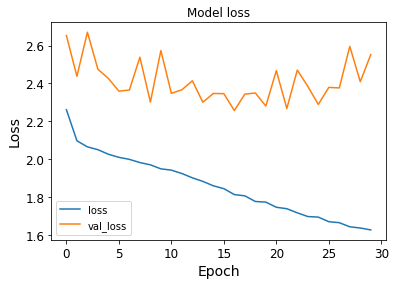

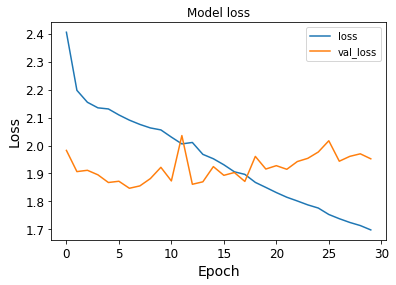

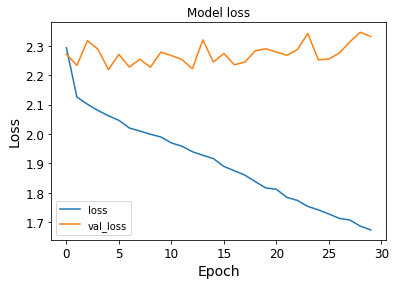

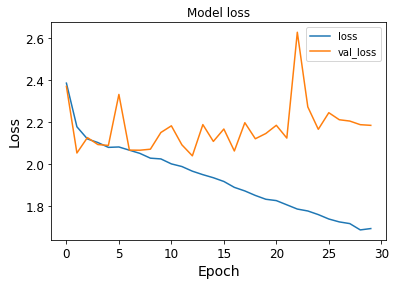

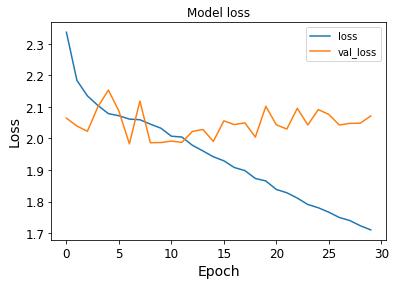

In [63]:
for hist in cv_history:
    plt.figure()
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot()
    plt.show()

In [64]:
from tqdm import tqdm_notebook

# average the prediction from the multiple folds

submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id', 
                         dtype={'time_to_failure': np.float32})

for fold in range(len(kFolds)):
    model.load_weights('signal-conv.{0}.ckpt.hdf5'.format(fold))
    for seg_id in tqdm_notebook(submission.index):
        seg = pd.read_csv(os.path.join('datasets/test/' + seg_id + '.csv'))
        X = SignalFeatures().generate(seg, predict=True)
        y = model.predict(X[np.newaxis, :])
        submission.loc[seg_id]['time_to_failure'] += y

submission['time_to_failure'] /= len(kFolds)
submission.to_csv('predictions/submission_keras_kernel.csv')

### Averaging CNN kernel and Feature models

In [266]:
submission_kernel = pd.read_csv('predictions/submission_keras_kernel.csv', index_col='seg_id')
submission_features = pd.read_csv('predictions/submission_blending.csv', index_col='seg_id')

In [267]:
submission_kernel.head()

,time_to_failure
seg_id,
seg_00030f,3.5541050
seg_0012b5,5.4497970
seg_00184e,5.3681070
seg_003339,8.4950285
seg_0042cc,6.8045310


In [268]:
submission_features.head()

,time_to_failure
seg_id,
seg_00030f,2.755833025437171
seg_0012b5,5.661783470714633
seg_00184e,5.303778652584595
seg_003339,8.225861378109185
seg_0042cc,6.339169543719258


In [264]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id', 
                         dtype={'time_to_failure': np.float32})

submission['time_to_failure'] = (submission_kernel['time_to_failure'] + submission_features['time_to_failure'])/2
submission.to_csv('predictions/submission_average_3.csv')

In [265]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.154969012718586
seg_0012b5,5.555790235357317
seg_00184e,5.335942826292298
seg_003339,8.360444939054592
seg_0042cc,6.571850271859629


In [271]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id', 
                         dtype={'time_to_failure': np.float32})

submission['time_to_failure'] = (submission_kernel['time_to_failure'] + 2*submission_features['time_to_failure'])/3
submission.to_csv('predictions/submission_average_4.csv')

In [270]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.288014341812390
seg_0012b5,5.520459156904877
seg_00184e,5.346664217528198
seg_003339,8.405306126036395
seg_0042cc,6.649410514573087


In [272]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id', 
                         dtype={'time_to_failure': np.float32})

submission['time_to_failure'] = prediction_cat
submission.to_csv('predictions/submission_cat.csv')

In [276]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id', 
                         dtype={'time_to_failure': np.float32})

prediction_cnn = pd.read_csv('predictions/submission_keras_kernel.csv', index_col='seg_id')['time_to_failure']
prediction_features_04 = pd.read_csv('predictions/submission_04_bis.csv', index_col='seg_id')['time_to_failure']

submission['time_to_failure'] = (prediction_cnn + prediction_features_04 + prediction_lgb 
                                 + prediction_svr1 + 4*prediction_cat)/8
submission.to_csv('predictions/submission_average_5.csv')

In [292]:
submission_read = pd.read_csv('predictions/submission_average_5.csv')
submission_read.mean(), submission_read.median(), submission_read.std()

(time_to_failure    5.512114096415642
 dtype: float64, time_to_failure    5.184293938759966
 dtype: float64, time_to_failure    2.217748792282534
 dtype: float64)